# **Neural Network model for bus delays**


### Load and prepare data

In [ ]:
import pandas as pd

df = pd.read_csv("Dataset-PT.csv",skiprows=1)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [ ]:
df.shape

(545103, 31)

In [ ]:
#Drop strings
df = df.drop(['Calendar_date', 'weather', 'temperature', 'day_of_week','time_of_day'], axis=1)

In [ ]:
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)


,arrival_delay
arrival_delay,1.000000
upstream_stop_delay,0.975019
origin_delay,0.716324
previous_bus_delay,0.265434
factor(day_of_week)weekend,0.190783
factor(time_of_day)Off-peak,0.138109
stop_sequence,0.092616
dwell_time,0.089433
travel_time_for_previous_section,0.081113
factor(weather)Normal,0.022642


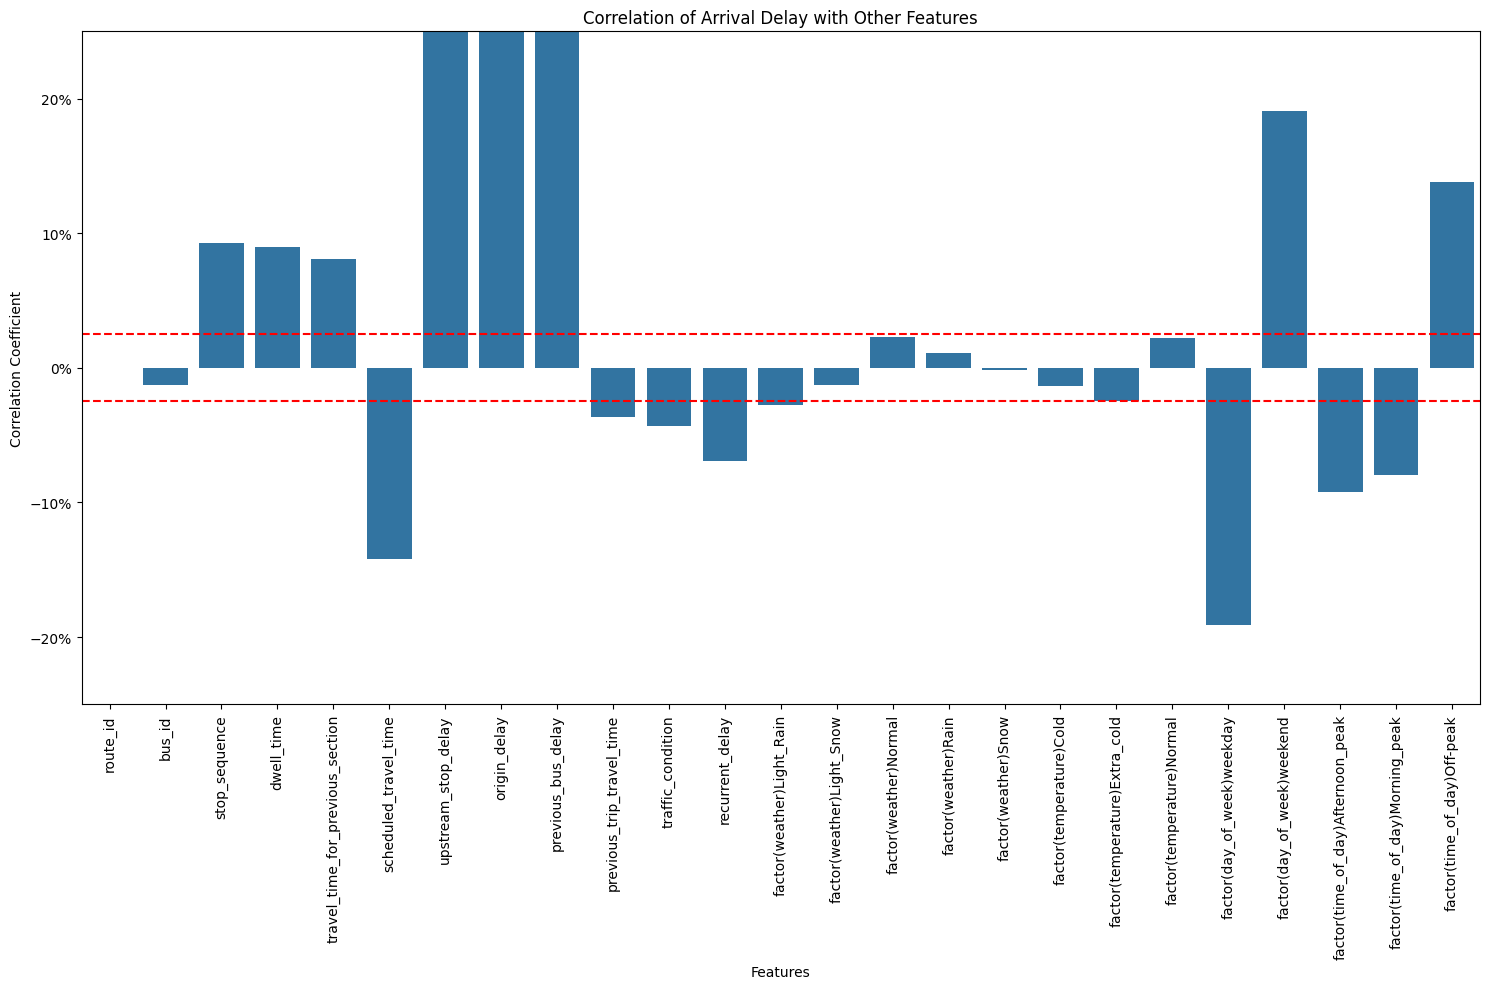

In [ ]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns

arrival_delay_corr = corr_matrix['arrival_delay'].drop('arrival_delay')

# Visualize the correlations using a bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x=arrival_delay_corr.index, y=arrival_delay_corr.values)
plt.title('Correlation of Arrival Delay with Other Features')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.ylim(-0.25, 0.25)
plt.axhline(y=0.025, color='red', linestyle='--', label='2.5%')
plt.axhline(y=-0.025, color='red', linestyle='--', label='-2.5%')
plt.xticks(rotation=45)
plt.xticks(rotation=90)

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
plt.tight_layout()
plt.show()

###Outlier detection and elimination

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Calculate the median of the arrival_delay column
median_origin_delay = np.median(df['origin_delay'])

# Step 2: Calculate the absolute distance from the median
df['distance_from_median'] = abs(df['origin_delay'] - median_origin_delay)

# Step 3: Sort by distance from the median in descending order
df_sorted = df.sort_values(by='distance_from_median', ascending=False)

# Step 4: Calculate how many rows correspond to 5% of the data
num_outliers = int(0.001 * len(df))

# Step 5: Mark top 5% rows as outliers (add 'outlier' attribute)
df_sorted['outlier'] = 0  # Default to 0 (not an outlier)
df_sorted.iloc[:num_outliers, df_sorted.columns.get_loc('outlier')] = 1  # Set top 5% as outliers

# Step 6: Identify all 'bus_id' that have at least one outlier
outlier_bus_ids = df_sorted[df_sorted['outlier'] == 1]['origin_delay'].unique()

# Step 7: Remove all rows that have a 'bus_id' in 'outlier_bus_ids'
df_final = df_sorted[~df_sorted['origin_delay'].isin(outlier_bus_ids)]

# Step 8: Drop temporary column 'distance_from_median'
df_final = df_final.drop(columns=['distance_from_median', 'outlier'])

# Optional: Display the results
print(f"Total buses with outliers: {len(outlier_bus_ids)}")
print(f"Number of initial outliers: {num_outliers}")
print(f"Number of rows after removing buses with outliers: {len(df_final)}")
print(f"Removed rows: {len(df)-len(df_final)}")

df = df_final

Total buses with outliers: 21
Number of initial outliers: 545
Number of rows after removing buses with outliers: 544536
Removed rows: 567


### further data preprocessing

Drop features with under 2,5% correlation

In [ ]:
df = df.drop(['bus_id',
              'route_id',
              'factor(weather)Normal',
              'factor(temperature)Normal',
              'factor(weather)Rain',
              'factor(weather)Snow',
              'factor(weather)Light_Snow',
              'factor(temperature)Cold',
              'factor(temperature)Extra_cold',
              'factor(weather)Light_Rain'],  axis=1)
              #'previous_trip_travel_time',
              #'traffic_condition'


Create x and y axis

In [ ]:
# Create a DataFrame 'x' containing all columns except 'Arrival_delay'.
x = df.drop(['arrival_delay'], axis=1)
#x består av Dwell_time, Scheduled travel time, upstream stop delay, recurrent delay

# Create a Series 'y' containing only the 'Arrival_delay' column.
y = df['arrival_delay']

# neural network model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def construct_network_model():
  # Create a Sequential model, which is a linear stack of layers.
  model = Sequential()

  # Add a Dense layer with 32 units, ReLU activation, and an input dimension of 4.
  model.add(Dense(32, activation='relu', input_dim=len(x.columns)))

  # Add another Dense layer with 64 units and ReLU activation.
  model.add(Dense(64, activation='relu'))

  model.add(Dense(64, activation='relu'))

  # Add a final Dense layer with 1 unit
  model.add(Dense(1))
  return model

Make the model

In [ ]:
model=construct_network_model()
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,849 (26.75 KB)

 Trainable params: 6,849 (26.75 KB)

 Non-trainable params: 0 (0.00 B)

## Training and prediction
Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets, with 80% for training and 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Standardization of data

In [ ]:
# separating binary features from continous features

binary = [ 'factor(day_of_week)weekday',
           'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
           'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak']

continous = ['stop_sequence', 'dwell_time', 'travel_time_for_previous_section',
             'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
             'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
             'recurrent_delay']


x_train_c = x_train[continous]
x_test_c = x_test[continous]

x_train_binary = x_train[binary]
x_test_binary = x_test[binary]
# -----------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# Standardize the continuous features
scaler = StandardScaler()
X_train_continous = scaler.fit_transform(x_train_c)
X_test_continous = scaler.transform(x_test_c)

# Convert the scaled continuous features back to DataFrames with their original columns
X_train_continous_df = pd.DataFrame(X_train_continous, columns=continous, index=x_train.index)
X_test_continous_df = pd.DataFrame(X_test_continous, columns=continous, index=x_test.index)

# Ensure binary data does not have NaNs and index issues
x_train_binary = x_train_binary.reset_index(drop=True)
x_test_binary = x_test_binary.reset_index(drop=True)

# Merge scaled continuous features with non-scaled binary features
X_train_scaled = pd.concat([X_train_continous_df.reset_index(drop=True), x_train_binary], axis=1)
X_test_scaled = pd.concat([X_test_continous_df.reset_index(drop=True), x_test_binary], axis=1)

Train model with callback function.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# use the callback function to early stop, learning rate ajusting, save the best model
# Create an EarlyStopping callback to monitor the validation mean absolute error (val_mae).
# It will stop training if val_mae doesn't improve for 10 consecutive epochs and restores the best weights.
early_stop = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Create a ReduceLROnPlateau callback to monitor val_mae.
# It reduces the learning rate by a factor of 0.5 if val_mae doesn't improve for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=4)

# Defin1e the file path where the best model weights will be saved.
filepath = "weights.best.h5.keras"
# Create a ModelCheckpoint callback to monitor the validation mae (val_mae).
# The callback will save thhe model's weights only if the validation mae improves.
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Train the model using the fit method.
hist = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=150, batch_size=16, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)


Epoch 1: val_mae improved from inf to 12.62090, saving model to weights.best.h5.keras

Epoch 2: val_mae improved from 12.62090 to 12.53074, saving model to weights.best.h5.keras

Epoch 3: val_mae did not improve from 12.53074

Epoch 4: val_mae did not improve from 12.53074

Epoch 5: val_mae improved from 12.53074 to 12.41249, saving model to weights.best.h5.keras

Epoch 6: val_mae did not improve from 12.41249

Epoch 7: val_mae improved from 12.41249 to 12.31149, saving model to weights.best.h5.keras

Epoch 8: val_mae improved from 12.31149 to 12.28655, saving model to weights.best.h5.keras

Epoch 9: val_mae did not improve from 12.28655

Epoch 10: val_mae did not improve from 12.28655

Epoch 11: val_mae did not improve from 12.28655

Epoch 12: val_mae improved from 12.28655 to 12.26159, saving model to weights.best.h5.keras

Epoch 13: val_mae did not improve from 12.26159

Epoch 14: val_mae did not improve from 12.26159

Epoch 15: val_mae did not improve from 12.26159

Epoch 16: val_

### Model evaluation

[]

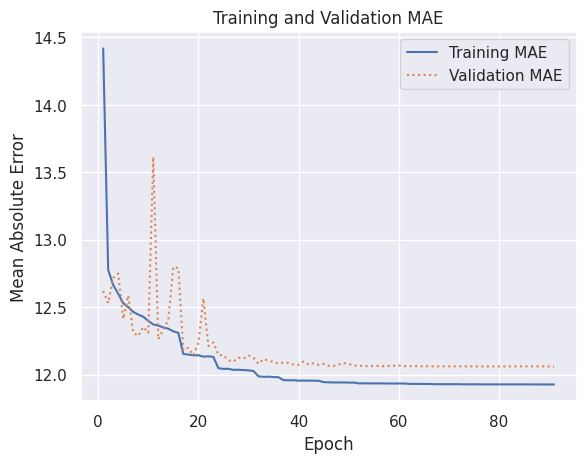

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots using Seaborn.
sns.set()
# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist.history['mae']
val_err = hist.history['val_mae']
# Define the number of epochs. = number of iterations to train the network
epochs = range(1, len(err) + 1)
# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

In [ ]:
# Use the trained model to predict on the test data.

from tensorflow.keras.models import load_model

if not filepath =="":
  # Load a pre-trained model from the specified file path.
  model = load_model(filepath)
  print('loading model')
  # Use the loaded model to predict on the test data.
  y_pred = model.predict(X_test_scaled)
else:
  print('not loading model')

loading model
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [ ]:
# saving model to use on scenarios
import joblib
joblib.dump(model, 'NN_model.pkl')

['NN_model.pkl']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the Mean Absolute Error (MAE) between the true and predicted values.
mae = mean_absolute_error(y_test, y_pred)
# Calculate the Mean Squared Error (MSE) between the true and predicted values.
mse = mean_squared_error(y_test, y_pred)
# Calculate the R-squared (R2) score, a measure of how well the model explains the variance in the data.
r2 = r2_score(y_test, y_pred)
# Print the calculated metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 11.913828722255573
Mean Squared Error: 367.3481936583256
R-squared: 0.9896799325942993


# Model Deployment

In [ ]:
#----------------------**Mapping**-------------------------------------------
# Dictionary mapping stop names to stop numbers
stop_mapping = {
    'skanstull': 1,
    'eriksdal': 2,
    'rosenlund': 3,
    'södrastation': 4,
    #Three names for the same station
    'hornsgatan/rosenlundsgatan': 5,
    'zinkensdamm': 6,
    'varvsgatan': 7,
    'hornstull': 8,
    'högalidsgatan': 9,
    'västerbroplan': 10,
    'mariebergsgatan': 11,
    'fridhemsplan': 12,
    'flemminggatan': 13,
    'steriksplan': 14,
    'dalagatan': 15,
    'odenplan': 16,
    'stadsbiblioteket': 17,
    'roslagsgatan': 18,
    'vallhallavägen': 19,
    'östrastation': 20,
    'stadion': 21,
    'musikhögskolan': 22,
    'jungfrugatan': 23,
    'värtavägen': 24,
    'banergatan': 25,
    'garnisonen': 26,
    'radiohuset': 27
}

# Function to get stop number from user input (either a number or a name)
def get_stop_number(prompt):
    user_input = input(prompt).strip().lower().replace(" ", "")  # Strip whitespace and make input lowercase

    # Check if the input is numeric and within the valid range (1-27)
    # This will return the number as an integer
    if user_input.isdigit() and 1 <= int(user_input) <= 27:
        return int(user_input)

    # Check if the input is a valid stop name
    elif user_input in stop_mapping:
        return stop_mapping[user_input]

    # If invalid, notify the user and ask again
    else:
        print("Invalid stop. Please enter a valid stop number (1-27) or stop name. Examples: Södra station, hornstull, steriksgatan")
        return get_stop_number(prompt)  # Recursively call until valid input
#----------------------**Mapping**-------------------------------------------

#----------------------**Functions to get time**-------------------------------------------
def get_time_factors():
    # Prompt for weekday/weekend
    time_of_week = input("Is it a weekday or weekend? (Enter 'weekday' or 'weekend'): ").strip().lower()

    if time_of_week == 'weekday':
        weekday = 1
        weekend = 0
    elif time_of_week == 'weekend':
        weekday = 0
        weekend = 1
    else:
        print("Invalid input. Please enter 'weekday' or 'weekend'.")
        return get_time_factors()

    # Prompt for time of day
    time_of_day = get_time_of_day()
    morning_peak, afternoon_peak, off_peak = time_of_day

    # if time_of_day == 'morning':
    #     morning_peak = 1
    #     afternoon_peak = 0
    #     off_peak = 0
    # elif time_of_day == 'afternoon':
    #     morning_peak = 0
    #     afternoon_peak = 1
    #     off_peak = 0
    # elif time_of_day == 'off-peak':
    #     morning_peak = 0
    #     afternoon_peak = 0
    #     off_peak = 1
    # else:
    #     raise ValueError("Invalid input. Please enter 'morning', 'afternoon', or 'off-peak'.")

    return {
        'factor(day_of_week)weekday': weekday,
        'factor(day_of_week)weekend': weekend,
        'factor(time_of_day)Afternoon_peak': afternoon_peak,
        'factor(time_of_day)Morning_peak': morning_peak,
        'factor(time_of_day)Off-peak': off_peak
    }

def get_time_of_day():
    time_of_day = input("Is it Morning peak, Afternoon peak, or Off-peak? (Enter 'morning', 'afternoon', or 'off-peak'): ").strip().lower()

    if time_of_day == 'morning':
        morning_peak = 1
        afternoon_peak = 0
        off_peak = 0
    elif time_of_day == 'afternoon':
        morning_peak = 0
        afternoon_peak = 1
        off_peak = 0
    elif time_of_day == 'off-peak':
        morning_peak = 0
        afternoon_peak = 0
        off_peak = 1
    else:
        print("Invalid input. Please enter 'morning', 'afternoon', or 'off-peak'.")
        return get_time_of_day()

    return morning_peak, afternoon_peak, off_peak
#----------------------**Functions to get time**-------------------------------------------

#----------------------**Get user info**-------------------------------------------
def get_user_input():
    get_off_stop = get_stop_number("Enter stop you're going to (1-27 or stop name). For example '1' or 'Östra station' ")
    # Collect input for the first 13 features
    user_data = {
        'stop_sequence': get_stop_number("Enter stop you're at (1-27 or stop name). For example '1' or 'Östra station' "),
        'dwell_time': int(input("Enter dwell_time (in seconds): ")),
        'travel_time_for_previous_section': int(input("Enter travel_time_for_previous_section (in seconds): ")),
        'scheduled_travel_time': int(input("Enter scheduled_travel_time (in seconds): ")),
        'upstream_stop_delay': int(input("Enter upstream_stop_delay (in seconds): ")),
        'origin_delay': int(input("Enter origin_delay (in seconds): ")),
        'previous_bus_delay': int(input("Enter previous_bus_delay (in seconds): ")),
        'recurrent_delay': float(input("Enter recurrent_delay (in seconds): ")),
        'previous_trip_travel_time' :float(input("Enter previous_trip_travel_time (in seconds): ")),
        'traffic_condition' :float(input("Enter traffic_condition (in seconds): ")),
    }

    time_factors = get_time_factors()
    user_data.update(time_factors)

    return user_data, get_off_stop

# # Getting input from user
# input_df = x_test
input_data, get_off_stop = get_user_input()
print(input_data)
input_df = pd.DataFrame([input_data])

#----------------------**Get user info**-------------------------------------------

##### RESCALING input #####
input_df_c = input_df[continous]
input_df_binary = input_df[binary]
input_df_continous = scaler.transform(input_df_c)
continous_input_df = pd.DataFrame(input_df_continous, columns = continous, index=input_df.index)
binary_input_df = input_df_binary.reset_index(drop=True)
# merge scaled continous features with non-scaled binary features
input_df_scaled = pd.concat([pd.DataFrame(input_df_continous, columns=input_df_c.columns), input_df_binary], axis=1)


# # Use the trained model (best_model) to make a prediction
prediction_start_station = model.predict(input_df_scaled)

input_df_scaled.loc[0, 'stop_sequence'] = get_off_stop
prediction_end_station = model.predict(input_df_scaled)

# # Output the prediction
print(f"Predicted arrival_delay at your station: {prediction_start_station[0]}")
print(f"Predicted arrival_delay at your destination: {prediction_end_station[0]}")